117


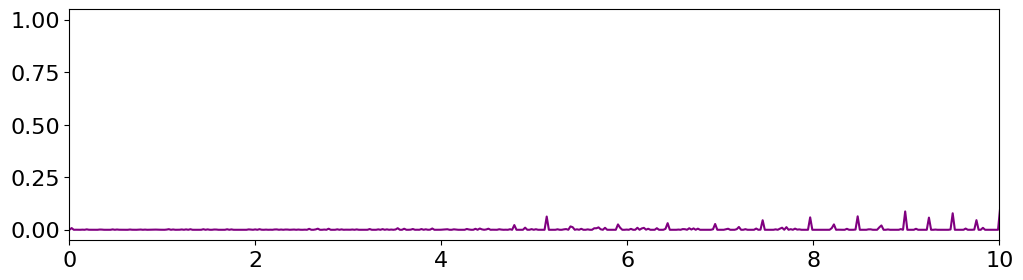

In [7]:
import numpy as np
from matplotlib import pyplot as plt
import librosa.display
from RhythmRecognition.constants import *
import matplotlib as mpl
from RhythmRecognition.onset import spectral
from RhythmRecognition.tempo import fourier
from RhythmRecognition.beat import score as score
from RhythmRecognition.rhythm import chorus_verse 
from RhythmRecognition.beat.click_track import *
import IPython.display as ipd
from scipy.io import wavfile as wav


mpl.rcParams.update({'font.size': 16})

audiofile = "../audio_files/spark.wav"
duration = 200  # how many seconds of the file will be processed

spectral_novelty = spectral.SpectralNovelty(audiofile, duration=duration)
spectral_novelty = spectral_novelty.get()

frames = np.arange(len(spectral_novelty))
t = librosa.frames_to_time(frames, sr=SAMPLING_RATE, hop_length=HOP_LENGTH)

fourier_tempo = fourier.FourierTempogram(spectral_novelty)
tempo = fourier_tempo.get_tempo()
print(tempo)

plt.figure(figsize=(12, 3))
plt.plot(t, spectral_novelty, 'purple')
plt.xlim(0,10)
plt.show()

In [8]:
beat_tracker = score.ScoreBeatTracker(spectral_novelty, tempo, duration)
shift = beat_tracker.get_time_shift()
print(shift)

0.005


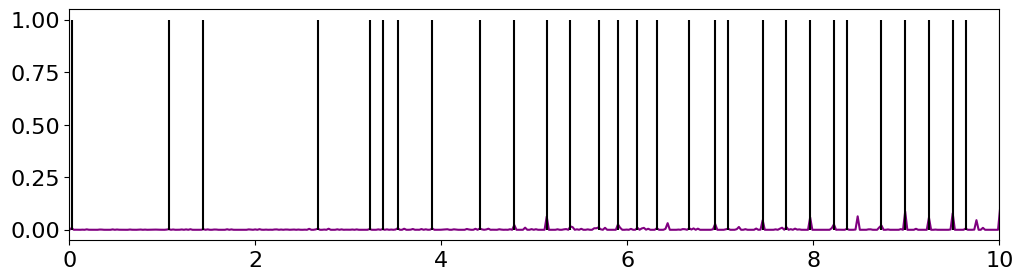

In [9]:
plt.figure(figsize=(12, 3))
plt.plot(t, spectral_novelty, 'purple')
plt.vlines(t[beat_tracker.peaks], 0, spectral_novelty.max(), color='black')
plt.xlim(0,10)
plt.show()

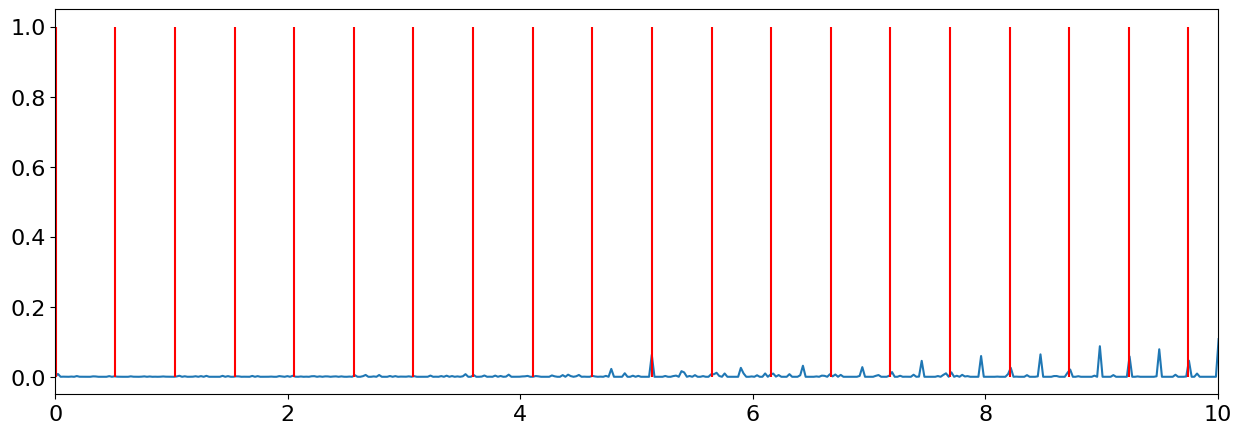

In [10]:
click_times_shifted = beat_tracker.get_beat_track()

plt.figure(figsize=(15, 5))
plt.plot(t, spectral_novelty)
plt.vlines(click_times_shifted, 0, spectral_novelty.max(), color='red')
plt.xlim(0, 10)    
plt.show()

In [11]:
signal2, sr = librosa.load(audiofile, duration=40, sr=SAMPLING_RATE)
click_track = librosa.clicks(times=click_times_shifted, sr=SAMPLING_RATE, length=len(signal2), hop_length=HOP_LENGTH)
ipd.Audio(signal2 + click_track, rate=SAMPLING_RATE)

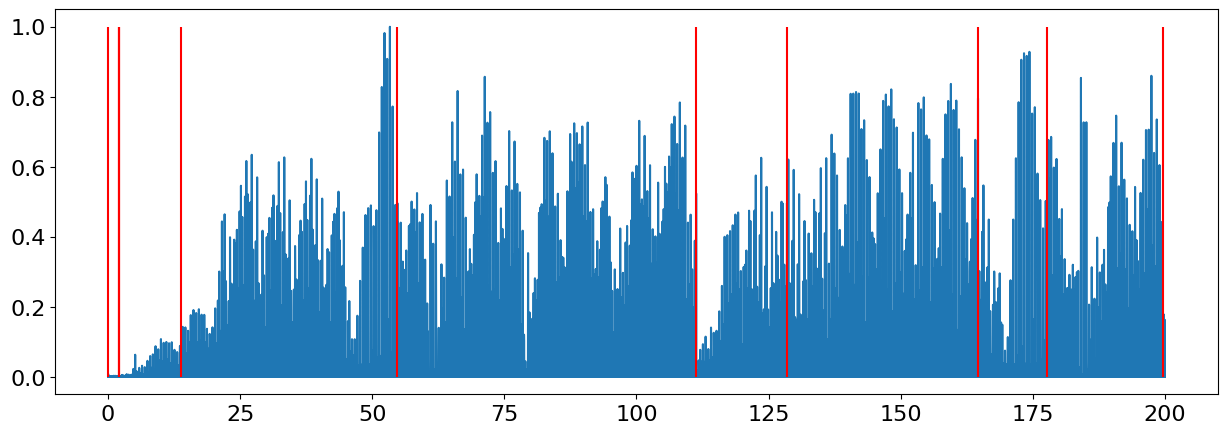

In [12]:
signal, sr = librosa.load(audiofile, duration=duration, sr=SAMPLING_RATE)
parts = chorus_verse.ChorusVerseRhythmTracker(audiofile, spectral_novelty, duration, tempo, click_times_shifted)
p = parts.find_song_parts()
plt.figure(figsize=(15, 5))
plt.plot(t, spectral_novelty)
plt.vlines(p, 0, spectral_novelty.max(), color='red')
plt.show()

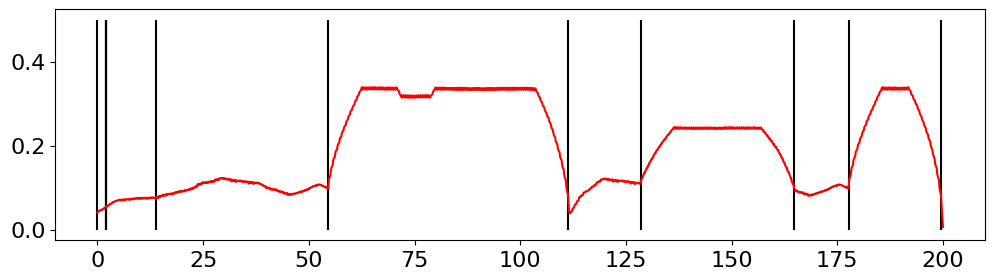

In [13]:
r = parts.compute_segment_rmse()
plt.figure(figsize=(12, 3))
plt.vlines(p, 0, spectral_novelty.max()/2, color='black')
plt.plot(t, r, color='red')
plt.show()


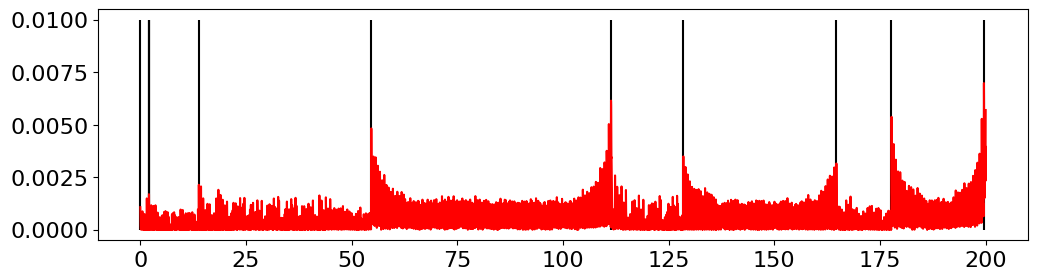

In [14]:
rmse_diff = np.diff(r)
rmse_diff = np.abs(rmse_diff)
plt.figure(figsize=(12, 3))
plt.vlines(p, 0, spectral_novelty.max()/100, color='black')
plt.plot(t[1:], rmse_diff, color='red')
plt.show()

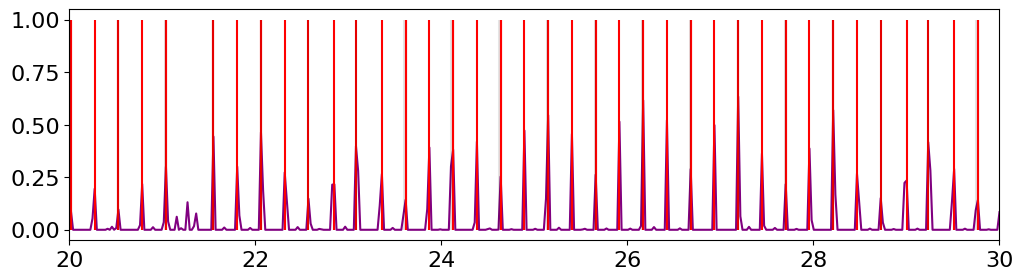

In [15]:
rhythm_rec = chorus_verse.ChorusVerseRhythmTracker(audiofile, spectral_novelty, duration, tempo, click_times_shifted)
r = rhythm_rec.find_rhythmic_onsets()
plt.figure(figsize=(12, 3))
plt.plot(t, spectral_novelty, 'purple')
plt.vlines(r, 0, spectral_novelty.max(), color='red')
plt.vlines(click_times_shifted, 0, spectral_novelty.max(), color='black', alpha=0.1)
plt.xlim(20, 30)
plt.show()

In [16]:
signal2, _ = librosa.load(audiofile, duration=40, sr=SAMPLING_RATE)
rhythm_track = librosa.clicks(times=r, sr=SAMPLING_RATE, length=len(signal2), hop_length=HOP_LENGTH)
ipd.Audio(signal2 + rhythm_track + click_track, rate=SAMPLING_RATE)

In [17]:
import pygame
pygame.init()

signal, _ = librosa.load(audiofile, duration=duration, sr=SAMPLING_RATE)

click_track = librosa.clicks(times=click_times_shifted, sr=SAMPLING_RATE, length=len(signal), hop_length=HOP_LENGTH)

rhythm_track = librosa.clicks(times=r, sr=SAMPLING_RATE, length=len(signal), hop_length=HOP_LENGTH)

wav.write("click.wav", SAMPLING_RATE, click_track.astype(signal.dtype))
wav.write("rhythm.wav", SAMPLING_RATE, rhythm_track.astype(signal.dtype))

sounds = []
sounds.append(pygame.mixer.Sound(audiofile))
# sounds.append(pygame.mixer.Sound('click.wav'))
sounds.append(pygame.mixer.Sound('rhythm.wav'))
for sound in sounds:
    sound.play()

pygame 2.5.2 (SDL 2.28.3, Python 3.11.9)
Hello from the pygame community. https://www.pygame.org/contribute.html
